<a href="https://colab.research.google.com/github/jay-thakur/CIFER-10-Exploration/blob/main/CIFER_10_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [177]:
cd '/content/drive/MyDrive/All/MS/DM/Notebooks/Assignments'

/content/drive/MyDrive/All/MS/DM/Notebooks/Assignments


# TRAINING A CLASSIFIER on CIFER10 dataset

CIFER-10 is dataset of 32*32 size colored images by [CIFER Institute](https://www.cs.toronto.edu/~kriz/cifar.html), which consists 10 classes ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck').

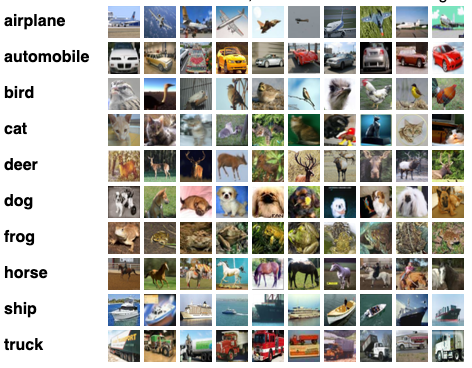

## Steps to Train an image classifier

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

In [178]:
# import all the required libraries
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

import time

## 1. Loading and Normalizing CIFAR10

In [179]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
print("Train Dataset : ", len(trainloader))

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
print("Test Dataset : ", len(testloader))

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Train Dataset :  12500
Files already downloaded and verified
Test Dataset :  2500


Let's see some of the training images

Images Shape :  (3, 32, 32)


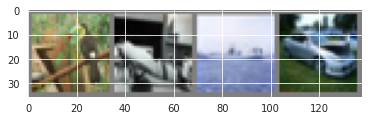

 bird plane  ship   car


In [180]:
# function to show an image
def imshow(img):
  img = img / 2 + 0.5 #unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get some training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

image_shape = images.numpy().shape[1:]
print("Images Shape : ", image_shape)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' %classes[labels[i]] for i in range(4)))

### 2. Define a Convolutional Neural Network

Let's understad **What is CNN ?**

A CNN is a type of neural network, empowered with some specific
hidden layers, including the Convolutional layer, the Pooling layer, and the Fully-Connected layer. CNN is mainly used in image processing applications.

A CNN classification netowrk - 

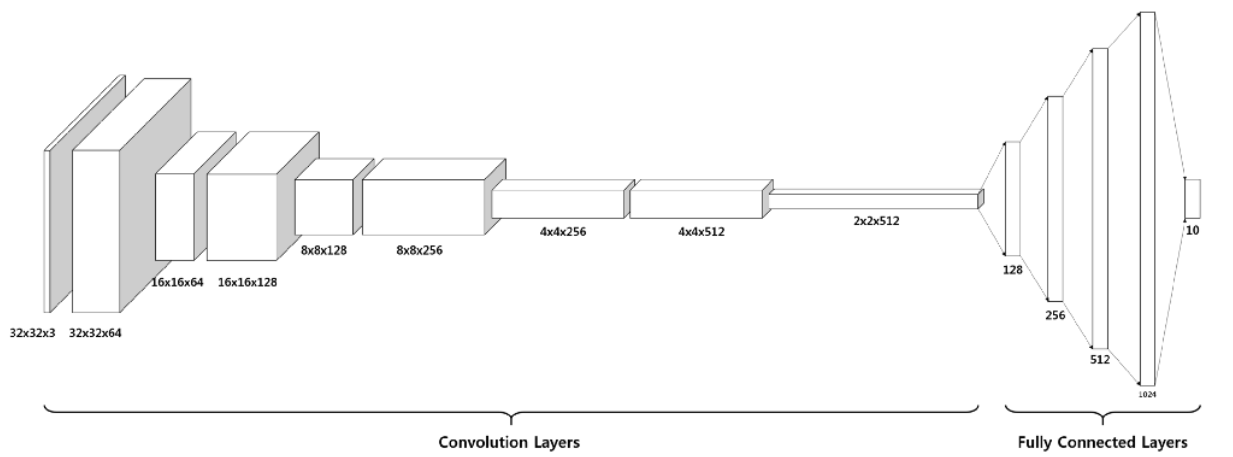

**Convolutional** - 

    torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')

Parameters

    in_channels (int) – Number of channels in the input image
    out_channels (int) – Number of channels produced by the convolution
    kernel_size (int or tuple) – Size of the convolving kernel
    stride (int or tuple, optional) – Stride of the convolution. (Default: 1)
    padding (int or tuple, optional) – Zero-padding added to both sides of the input (Default: 0)
    padding_mode (string, optional) – zeros
    dilation (int or tuple, optional) – Spacing between kernel elements. (Default: 1)
    groups (int, optional) – Number of blocked connections from input to output channels. (Default: 1)
    bias (bool, optional) – If True, adds a learnable bias to the output. (Default: True)


**Maxpool** - 

Max pooling is a sample-based discretization process. The objective is to down-sample an input representation (image, hidden-layer output matrix, etc.), reducing its dimensionality and allowing for assumptions to be made about features contained in the sub-regions binned

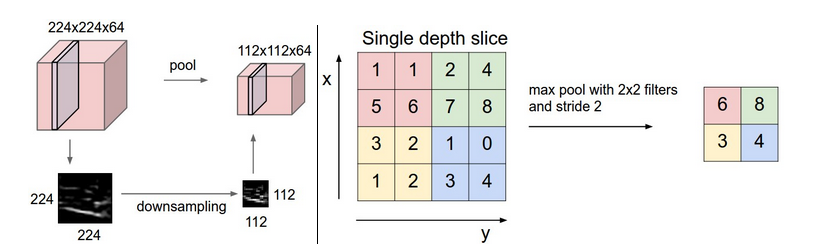




**Activation Functions**

the [activation function](https://en.wikipedia.org/wiki/Activation_function) of a node defines the output of that node given an input or set of inputs. 
perform a transformation on the input received, in order to keep values within a manageable range.

Some of Activation Functions are - 

1. Sigmoid - It produces value in range of (0, 1) & is defind as.
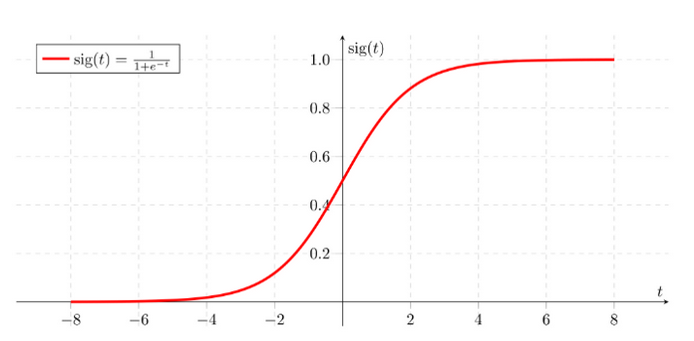

2. Tanh - tanh produces value in range of (-1, 1) & is defind as
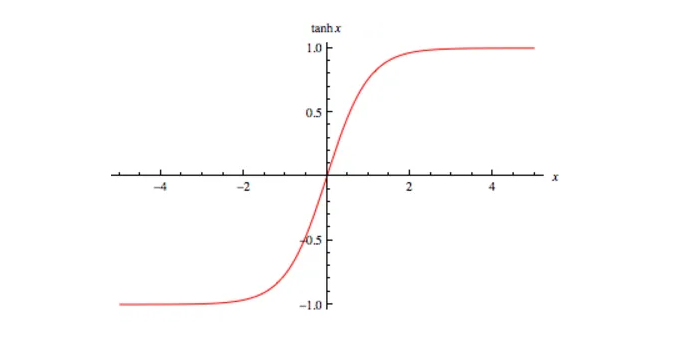

3. ReLU : ReLU (Rectified Linear Unit) is defined as f(x) = max(0,x)

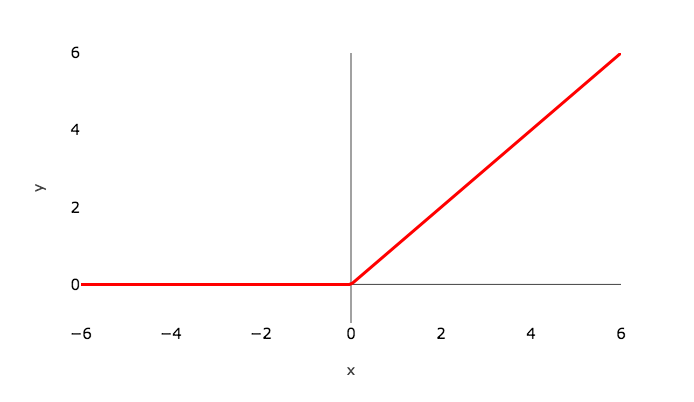

4. Leaky ReLU - It is defined as f(x) = max(αx, x)

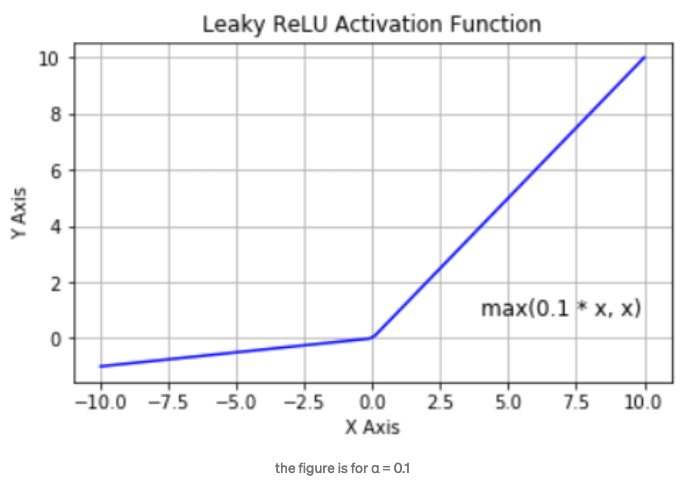

In [181]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [182]:
# Define a Neural Network with 2 convolution layer for 3 channel images 
class Net2CL(nn.Module):
  def __init__(self):
    super(Net2CL, self).__init__()

    # conv layers
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.conv2 = nn.Conv2d(6, 16, 5)

    # pooling layers
    self.pool = nn.MaxPool2d(2, 2)
    
    # fully connected layers
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))

    x = x.view(-1, 16 * 5 * 5)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net2cl = Net2CL()
net2cl = net2cl.to(device)

In [183]:
input_shape = image_shape # (3, 32, 32)
summary(net2cl, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [184]:
# Define a Neural Network with 3 convolution layer for 3 channel images 
class Net3CL(nn.Module):
  def __init__(self):
    super(Net3CL, self).__init__()

    # conv layers
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

    # pooling layers
    self.pool = nn.MaxPool2d(2, 2)
    
    # fully connected layers
    self.fc1 = nn.Linear(64 * 4 * 4, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))

    x = x.view(-1, 64 * 4 * 4)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net3cl = Net3CL()
net3cl = net3cl.to(device)
summary(net3cl, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]               0
            Linear-7                  [-1, 512]         524,800
            Linear-8                  [-1, 256]         131,328
            Linear-9                   [-1, 10]           2,570
Total params: 682,282
Trainable params: 682,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.28
Params size (MB): 2.60
Estimated Total Size (MB): 2.89
-------------------------------------------

In [185]:
# Define a Neural Network with 4 convolution layer for 3 channel images 
class Net4CL(nn.Module):
  def __init__(self):
    super(Net4CL, self).__init__()

        # conv layers
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv4 = nn.Conv2d(64, 128, 3, padding=1)

    # pooling layers
    self.pool = nn.MaxPool2d(2, 2)

    # dropout layer
    self.dropout = nn.Dropout(0.1)
    
    # fully connected layers
    self.fc1 = nn.Linear(128 * 2 * 2, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)

    # self.fc2 = nn.Linear(512, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = self.pool(F.relu(self.conv4(x)))

    x = x.view(-1, 128 * 2 * 2)

    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net4cl = Net4CL()
net4cl = net4cl.to(device)

summary(net4cl, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
         MaxPool2d-8            [-1, 128, 2, 2]               0
           Dropout-9                  [-1, 512]               0
           Linear-10                  [-1, 512]         262,656
          Dropout-11                  [-1, 512]               0
           Linear-12                  [-1, 256]         131,328
           Linear-13                   [-1, 10]           2,570
Total params: 493,994
Trainable params:

## 3. Define a Loss function and optimizer

### Different Loss functions:

It’s a method of evaluating how well specific algorithm models the given data. If predictions deviates too much from actual results, loss function would cough up a very large number. 

**Common functions to calculate loss for Classification task**

    Binary Cross Entropy Loss — torch.nn.BCELoss()
    Binary Cross Entropy with Logits Loss — torch.nn.BCEWithLogitsLoss()
    Negative Log Likelihood — torch.nn.NLLLoss()
    CrossEntropyLoss — torch.nn.CrossEntropyLoss() - Most Common

**Cross-Entropy Loss**

It measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. So predicting a probability of .012 when the actual observation label is 1 would be bad and result in a high loss value. A perfect model would have a log loss of 0.

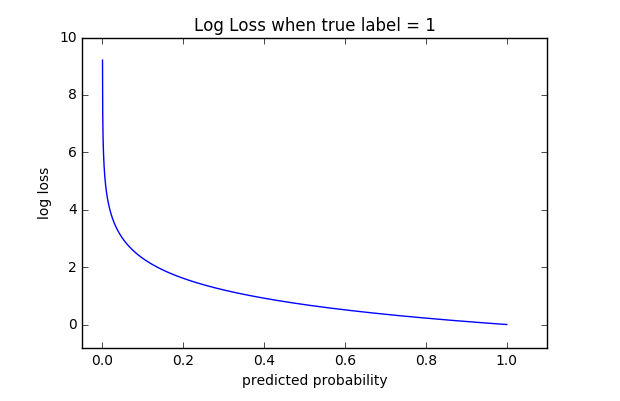


In [186]:
def choose_loss_function(lf):
  if lf == "BCE":
    return nn.BCELoss()
  elif lf == "BCEwL":
    return nn.BCEWithLogitsLoss()
  elif lf == "NLL":
    return nn.NLLLoss()
  elif lf == "CE":
    return nn.CrossEntropyLoss()

### Optimizers

The optimizer takes the parameters we want to update, the learning rate we want to use (and possibly many other parameters as well, and performs the updates through its `step()` method.

Different Optimizers are - 

1. torch.optim.Adagrad
2. torch.optim.Adam
3. torch.optim.Adamax
4. torch.optim.ASGD
5. torch.optim.LBFGS
6. torch.optim.RMSProp
7. torch.optim.Rprop
8. torch.optim.SGD

In [187]:
# learning_rate = 0.01
# learning_rate = 0.001
learning_rate = 0.0001

def choose_optimiser(net, optimiser):

  if optimiser == "Adam":
    return optim.Adam(net.parameters(), lr=learning_rate)
  elif optimiser == "Adamax":
    return optim.Adamax(net.parameters(), lr=learning_rate)
  elif optimiser == "ASGD":
    return optim.ASGD(net.parameters(), lr=learning_rate)
  elif optimiser == "LBFGS":
    return optim.LBFGS(net.parameters(), lr=learning_rate)
  elif optimiser == "RMSprop":
    return  optim.RMSprop(net.parameters(), lr=learning_rate)
  elif optimiser == "Rprop":
    return  optim.Rprop(net.parameters(), lr=learning_rate)
  elif optimiser == "SGD":
    return optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

### 4. Train the network

In [188]:
# Train the network
num_epochs = 5
time_elapsed_list = []

def fit(model, trainloader, optimizer, criterion):
  history = []
  print("Training Started..")
  since = int(round(time.time()*1000))
  for epoch in range(num_epochs):
    training_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      # get the inputs
      inputs, labels = data

      # Zero the parameter gradients
      optimizer.zero_grad()

      # Forward + backward + optimize
      outputs = model(inputs)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      #print statistics
      training_loss += loss.item()
      if i % 6000 == 5999: # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, training_loss / 6000))
        training_loss = 0.0
    
    # calculate average losses
    training_loss = training_loss/len(trainloader)
    history.append(training_loss)

  time_elapsed = int(round(time.time()*1000)) - since
  print("Training Finished.")
  return history, time_elapsed


In [189]:
def choose_model(model):
  if model == "Net2CL":
    return Net2CL()
  elif model == "Net3CL":
    return Net3CL()
  elif model == "Net4CL":
    return Net4CL()

In [190]:
# save the model
def save_model(net, model):
  # lets save our trained model
  PATH = './cifer_'+net+'.pth'
  torch.save(model.state_dict(), PATH)

In [191]:
# Plot the loss and accuracy curves for training
sns.set_style('darkgrid')
# plt.style.use('ggplot')
def plot_loss_per_epoch(history):
  plt.plot(np.arange(0, num_epochs), history, label='training_loss')
  plt.title('Loss')
  plt.xlabel('No of epochs')
  plt.ylabel('Loss')
  plt.legend(loc='upper right')
  plt.show()

Training Started..
[1,  6000] loss: 2.294
[1, 12000] loss: 2.135
[2,  6000] loss: 1.900
[2, 12000] loss: 1.739
[3,  6000] loss: 1.634
[3, 12000] loss: 1.566
[4,  6000] loss: 1.504
[4, 12000] loss: 1.457
[5,  6000] loss: 1.416
[5, 12000] loss: 1.386
Training Finished.


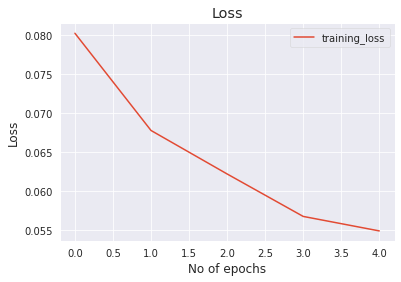

In [192]:
# SGD optimizer & Cross_Entropy_Loss
net = "Net2CL" # Net2CL - 2 conv layer net, Net3CL - 3 conv layer net, Net4CL - 4 conv layer net
model = choose_model(net)
opt = "SGD" # SGD - Stocastic, 
optimizer = choose_optimiser(model, opt)

lf = "CE" #CE - Cross Entropy, BCE - BCELoss, BCEwL - BCE with Logits loss, NLL - NLLLoss, 
criterion = choose_loss_function(lf)

history, time_elapsed = fit(model, trainloader, optimizer, criterion)
# print("time elapsed : ", str(time_elapsed) + ' ms')
time_elapsed_list.append(time_elapsed)

save_model(net, model)

plot_loss_per_epoch(history)

### 5. Test the network on the test data

we have trained the network, now let's check if it has learnt anything

we will predict this by predicting the class label

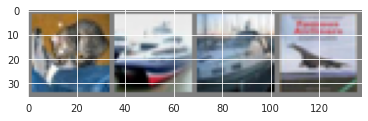

GroundTruth:    cat  ship  ship plane


In [193]:
dataiter = iter(testloader)
images, labels = dataiter.next()

#print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' %classes[labels[j]] for j in range(4)))

In [194]:
# model.load_state_dict(torch.load(PATH))

In [195]:
outputs = model(images)

In [196]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' %classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship   car  ship


Lets see how the network performs on the whole dataset

In [197]:
# function to calcualte accuracy
def accuracy(net, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
    for data in dataloader:
      images, labels = data
      outputs = net(images)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  accuracy = (100*correct / total)
  print('Accuracy of the network on the 10000 test images: %d%%' %accuracy)
  return accuracy

In [198]:
class_correct = list(0 for i in range(10))
class_total = list(0 for i in range(10))
class_accuracy = list(0 for i in range(10))

def accuracy_of_classes(net, dataloader):
  with torch.no_grad():
    for data in dataloader:
      images, labels = data
      outputs = net(images)
      _, predicted = torch.max(outputs, 1)
      c = (predicted == labels).squeeze()
      for i in range(4):
        label = labels[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1

  for i in range(10):
    class_accuracy[i] = 100 * class_correct[i] / class_total[i]
    print('Accuracy of %5s : %2d %%' %(classes[i], 100 * class_correct[i] / class_total[i]))

In [199]:
def plot_classes_accuracy(classes, class_accuracy):
  # sns.barplot(classes, class_accuracy)
  plt.bar(classes, class_accuracy)
  plt.xlabel("Class")
  plt.ylabel("Accuracy")
  plt.show()

let's see what are the classes performed well

Accuracy of the network on the 10000 test images: 50%
Accuracy of plane : 43 %
Accuracy of   car : 68 %
Accuracy of  bird : 41 %
Accuracy of   cat : 19 %
Accuracy of  deer : 38 %
Accuracy of   dog : 55 %
Accuracy of  frog : 58 %
Accuracy of horse : 56 %
Accuracy of  ship : 71 %
Accuracy of truck : 54 %


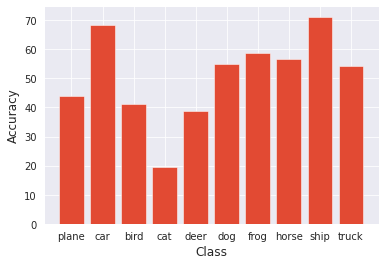

In [200]:
# total accuracy on test images
nets_accuracy = []

net2cl_accuracy = accuracy(model, testloader)
nets_accuracy.append(net2cl_accuracy)

# accuracy of classes on test images
accuracy_of_classes(model, testloader)

#plot each class accuracy
plot_classes_accuracy(classes, class_accuracy)

Training Started..
[1,  6000] loss: 1.685
[1, 12000] loss: 1.395
[2,  6000] loss: 1.259
[2, 12000] loss: 1.157
[3,  6000] loss: 1.049
[3, 12000] loss: 0.994
[4,  6000] loss: 0.911
[4, 12000] loss: 0.880
[5,  6000] loss: 0.797
[5, 12000] loss: 0.792
Training Finished.


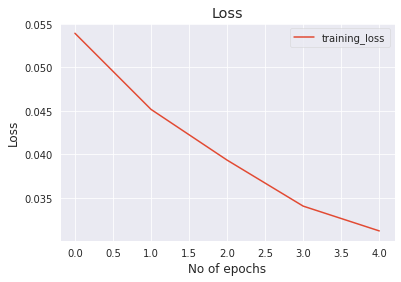

In [201]:
# SGD optimizer & Cross_Entropy_Loss
net = "Net3CL" # Net2CL - 2 conv layer net, Net3CL - 3 conv layer net, Net4CL - 4 conv layer net
model = choose_model(net)
# opt = "SGD" # SGD - Stocastic, 67%
opt = "Adam" # SGD - Stocastic, 69\
optimizer = choose_optimiser(model, opt)

lf = "CE" #CE - Cross Entropy, BCE - BCELoss, BCEwL - BCE with Logits loss, NLL - NLLLoss, 
criterion = choose_loss_function(lf)

history, time_elapsed = fit(model, trainloader, optimizer, criterion)

time_elapsed_list.append(time_elapsed)

save_model(net, model)

plot_loss_per_epoch(history)

Accuracy of the network on the 10000 test images: 70%
Accuracy of plane : 59 %
Accuracy of   car : 75 %
Accuracy of  bird : 49 %
Accuracy of   cat : 35 %
Accuracy of  deer : 49 %
Accuracy of   dog : 57 %
Accuracy of  frog : 68 %
Accuracy of horse : 65 %
Accuracy of  ship : 78 %
Accuracy of truck : 66 %


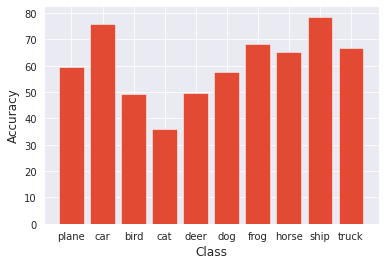

In [202]:
# total accuracy on test images
net3cl_accuracy = accuracy(model, testloader)
nets_accuracy.append(net3cl_accuracy)

# accuracy of classes on test images
accuracy_of_classes(model, testloader)

#plot each class accuracy
plot_classes_accuracy(classes, class_accuracy)

Training Started..
[1,  6000] loss: 1.752
[1, 12000] loss: 1.482
[2,  6000] loss: 1.331
[2, 12000] loss: 1.247
[3,  6000] loss: 1.149
[3, 12000] loss: 1.082
[4,  6000] loss: 0.998
[4, 12000] loss: 0.960
[5,  6000] loss: 0.879
[5, 12000] loss: 0.863
Training Finished.


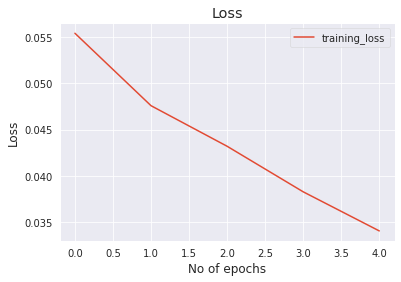

In [203]:
# SGD optimizer & Cross_Entropy_Loss
net = "Net4CL" # Net2CL - 2 conv layer net, Net3CL - 3 conv layer net, Net4CL - 4 conv layer net
model = choose_model(net)

opt = "Adam" # SGD - Stocastic, 
# opt = "SGD" # SGD - Stocastic, 
optimizer = choose_optimiser(model, opt)
# optimizer = optim.Adam(Net4CL().parameters())

lf = "CE" #CE - Cross Entropy, BCE - BCELoss, BCEwL - BCE with Logits loss, NLL - NLLLoss, 
criterion = choose_loss_function(lf)

history, time_elapsed = fit(model, trainloader, optimizer, criterion)

time_elapsed_list.append(time_elapsed)

save_model(net, model)

plot_loss_per_epoch(history)

Accuracy of the network on the 10000 test images: 66%
Accuracy of plane : 64 %
Accuracy of   car : 72 %
Accuracy of  bird : 55 %
Accuracy of   cat : 40 %
Accuracy of  deer : 49 %
Accuracy of   dog : 56 %
Accuracy of  frog : 73 %
Accuracy of horse : 65 %
Accuracy of  ship : 78 %
Accuracy of truck : 70 %


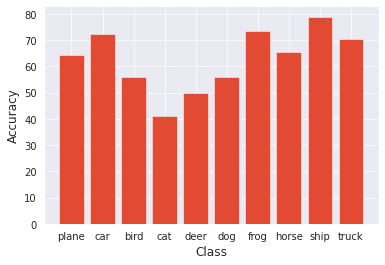

In [204]:
# total accuracy on test images
net4cl_accuracy = accuracy(model, testloader)
nets_accuracy.append(net4cl_accuracy)

# accuracy of classes on test images
accuracy_of_classes(model, testloader)

#plot each class accuracy
plot_classes_accuracy(classes, class_accuracy)

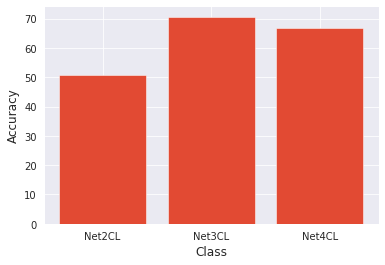

In [205]:
# accuracies comparison

net_classes = ['Net2CL', 'Net3CL', 'Net4CL']

plot_classes_accuracy(net_classes, nets_accuracy)

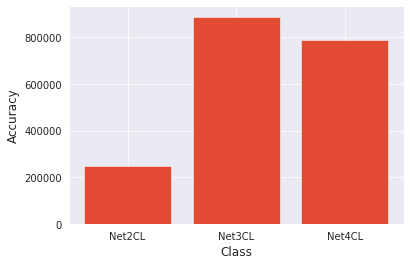

In [206]:
plot_classes_accuracy(net_classes, time_elapsed_list)

# References

https://www.cs.toronto.edu/~kriz/cifar.html

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

https://towardsdatascience.com/pytorch-basics-how-to-train-your-neural-net-intro-to-cnn-26a14c2ea29

https://sgugger.github.io/convolution-in-depth.html

https://www.researchgate.net/figure/Learning-hierarchy-of-visual-features-in-CNN-architecture_fig1_281607765

https://cs231n.github.io/convolutional-networks/#conv

https://medium.com/@RaghavPrabhu/understanding-of-convolutional-neural-network-cnn-deep-learning-99760835f148

https://medium.com/technologymadeeasy/the-best-explanation-of-convolutional-neural-networks-on-the-internet-fbb8b1ad5df8


https://pytorch.org/docs/stable/nn.html

https://datascience.stackexchange.com/questions/40906/determining-size-of-fc-layer-after-conv-layer-in-pytorch

https://stackoverflow.com/questions/56675943/meaning-of-parameters-in-torch-nn-conv2d

https://datascience.stackexchange.com/questions/40906/determining-size-of-fc-layer-after-conv-layer-in-pytorch

https://computersciencewiki.org/index.php/Max-pooling_/_Pooling

https://towardsdatascience.com/everything-you-need-to-know-about-activation-functions-in-deep-learning-models-84ba9f82c253

https://heartbeat.fritz.ai/the-right-loss-function-pytorch-58d2c0d77404

https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7

https://neptune.ai/blog/pytorch-loss-functions

https://towardsdatascience.com/common-loss-functions-in-machine-learning-46af0ffc4d23

https://phuctrt.medium.com/loss-functions-why-what-where-or-when-189815343d3f

https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6

https://analyticsindiamag.com/ultimate-guide-to-pytorch-optimizers/


